# 进程和线程

**1.多进程**

In [ ]:
import os
#只能在Unix上运行
#pid = os.fork()

In [ ]:
from multiprocessing import Process
#跨平台的多进程模块

# 子进程要执行的代码
def run_proc(name):
    print('Run child process %s (%s)...' % (name, os.getpid()))

if __name__=='__main__':
    print('Parent process %s.' % os.getpid())
    p = Process(target=run_proc, args=('test',))
    print('Child process will start.')
    p.start()#启动子进程
    p.join()#等待子进程结束
    print('Child process end.')

Pool如果要启动大量子进程，用进程池的方式批量创建

In [ ]:
from multiprocessing import Pool
import os, time

def long_time_task(name):
    print('Run task %s (%s)...' % (name, os.getpid()))
    start = time.time()
    time.sleep(1)
    end = time.time()
    print('Task %s runs %0.2f seconds.' % (name, (end - start)))

if __name__=='__main__':
    print('Parent process %s.' % os.getpid())
    p = Pool(4)
    for i in range(5):
        p.apply_async(long_time_task, args=(i,))
    print('Waiting for all subprocesses done...')
    p.close()
    p.join()
    print('All subprocesses done.')

subprocess控制子进程的操作,，类似于C中exec家族函数

In [ ]:
import subprocess

r = subprocess.call(['ping','www.baidu.com'])

如果子进程还需要输入，通过communicate()函数

In [ ]:
import subprocess

p = subprocess.Popen(['nslookup'], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, err = p.communicate(b'set q=mx\npython.org\nexit\n')
print(output.decode('utf-8'))
print('Exit code:', p.returncode)

进程间通信Queue

In [ ]:
from multiprocessing import Process, Queue
import os

# 写数据进程执行的代码:
def write(q):
    print('Process to write: %s' % os.getpid())
    for value in ['A', 'B', 'C']:
        print('Put %s to queue...' % value)
        q.put(value)

# 读数据进程执行的代码:
def read(q):
    print('Process to read: %s' % os.getpid())
    while True:
        value = q.get(True)
        print('Get %s from queue.' % value)

if __name__=='__main__':
    # 父进程创建Queue，并传给各个子进程：
    q = Queue()
    pw = Process(target=write, args=(q,))
    pr = Process(target=read, args=(q,))
    # 启动子进程pw，写入:
    pw.start()
    # 启动子进程pr，读取:
    pr.start()
    # 等待pw结束:
    pw.join()
    # pr进程里是死循环，无法等待其结束，只能强行终止:
    pr.terminate()

**2.多线程**

In [ ]:
import threading

# 新线程执行的代码:
def loop():
    print('thread %s is running...' % threading.current_thread().name)

print('thread %s is running...' % threading.current_thread().name)
t = threading.Thread(target=loop, name='LoopThread')
t.start()
t.join()
print('thread %s ended.' % threading.current_thread().name)

锁

In [ ]:
lock = threading.Lock()

def run_thread(n):
    # 先要获取锁:
    lock.acquire()
    try:
        # 放心地改吧:
        pass
    finally:
        # 改完了一定要释放锁:
        lock.release()

In [ ]:
import multiprocessing
#CPU核数量
multiprocessing.cpu_count()

因为Python的线程虽然是真正的线程，但解释器执行代码时，有一个GIL锁：Global Interpreter Lock，任何Python线程执行前，必须先获得GIL锁，然后，每执行100条字节码，解释器就自动释放GIL锁，让别的线程有机会执行。这个GIL全局锁实际上把所有线程的执行代码都给上了锁，所以，多线程在Python中只能交替执行，即使100个线程跑在100核CPU上，也只能用到1个核。

**3.多线程局部变量ThreadLocal**

一个ThreadLocal变量虽然是全局变量，但每个线程都只能读写自己线程的独立副本，互不干扰。ThreadLocal解决了参数在一个线程中各个函数之间互相传递的问题。

In [1]:
import threading

# 创建全局ThreadLocal对象:
local_school = threading.local()

def process_student():
    # 获取当前线程关联的student:
    std = local_school.student
    print('Hello, %s (in %s)' % (std, threading.current_thread().name))

def process_thread(name):
    # 绑定ThreadLocal的student:
    local_school.student = name
    process_student()

t1 = threading.Thread(target= process_thread, args=('Alice',), name='Thread-A')
t2 = threading.Thread(target= process_thread, args=('Bob',), name='Thread-B')
t1.start()
t2.start()
t1.join()
t2.join()

Hello, Alice (in Thread-A)
Hello, Bob (in Thread-B)


**4.分布式进程**

参考源码task_master.py和task_worker.py

这个简单的Master/Worker模型有什么用？其实这就是一个简单但真正的分布式计算，把代码稍加改造，启动多个worker，就可以把任务分布到几台甚至几十台机器上，比如把计算n\*n的代码换成发送邮件，就实现了邮件队列的异步发送。

Queue对象存储在哪？注意到task_worker.py中根本没有创建Queue的代码，所以，Queue对象存储在task_master.py进程中：

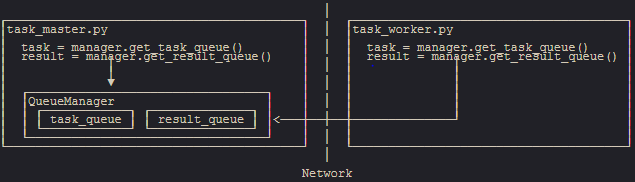

而Queue之所以能通过网络访问，就是通过QueueManager实现的。由于QueueManager管理的不止一个Queue，所以，要给每个Queue的网络调用接口起个名字，比如get_task_queue。

authkey有什么用？这是为了保证两台机器正常通信，不被其他机器恶意干扰。如果task_worker.py的authkey和task_master.py的authkey不一致，肯定连接不上

注意Queue的作用是用来传递任务和接收结果，每个任务的描述数据量要尽量小。比如发送一个处理日志文件的任务，就不要发送几百兆的日志文件本身，而是发送日志文件存放的完整路径，由Worker进程再去共享的磁盘上读取文件。